## Text classification using tensorflow
* Main source: `https://www.tensorflow.org/tutorials/keras/basic_text_classification`

* Explanation of the embedding layer: `https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/`

* Keras text preprocessing: `https://keras.io/preprocessing/text/#tokenizer`

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
print tf.__version__

/Users/lduque/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


### Load the imdb dataset
Each training row is an encoded imdb review and the target is 0 for negative reviews and 1 for positive ones

In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

print len(train_data)
pd.Series([len(v) for v in train_data]).hist(bins=30, figsize=(10,5));
pd.Series(train_labels).value_counts().plot.bar(title='target');

25000


In [3]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [4]:
print '\ttrain_data before padding'
print '\n (*) train_data[0] = ', train_data[0]
print '\n (*) decode_review(train_data[0]) = ', decode_review(train_data[0])

	train_data before padding

 (*) train_data[0] =  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

 (*) deco

### Data preprocessing: padding
i.e. we force every review to have a length of 256 by adding zeros at the end

In [5]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [6]:
print '\ttrain_data after padding'
print '\n (*) train_data[0] = ', train_data[0]
print '\n (*) decode_review(train_data[0]) = ', decode_review(train_data[0])

	train_data after padding

 (*) train_data[0] =  [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 55

### Create a keras model
The layers are stacked sequentially to build the classifier:

The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

In [7]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [10]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

/Users/lduque/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 40us/step - loss: 0.6921 - acc: 0.5723 - val_loss: 0.6904 - val_acc: 0.6185
Epoch 2/40
15000/15000 [==============================] - 0s 20us/step - loss: 0.6869 - acc: 0.6815 - val_loss: 0.6830 - val_acc: 0.7467
Epoch 3/40
15000/15000 [==============================] - 0s 20us/step - loss: 0.6752 - acc: 0.7612 - val_loss: 0.6678 - val_acc: 0.7553
Epoch 4/40
15000/15000 [==============================] - 0s 21us/step - loss: 0.6535 - acc: 0.7619 - val_loss: 0.6430 - val_acc: 0.7650
Epoch 5/40
15000/15000 [==============================] - 0s 19us/step - loss: 0.6200 - acc: 0.7889 - val_loss: 0.6064 - val_acc: 0.7820
Epoch 6/40
15000/15000 [==============================] - 0s 21us/step - loss: 0.5765 - acc: 0.8051 - val_loss: 0.5638 - val_acc: 0.7941
Epoch 7/40
15000/15000 [==============================] - 0s 21us/step - loss: 0.5275 - acc: 0.8249 - val_loss: 0.5187 - val_acc

In [11]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 0s 15us/step
[0.33258376961231234, 0.8724]


In [12]:
history_dict = history.history
history_dict.keys()

['acc', 'loss', 'val_acc', 'val_loss']

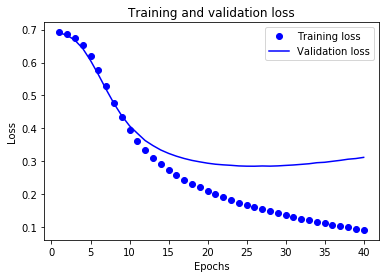

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

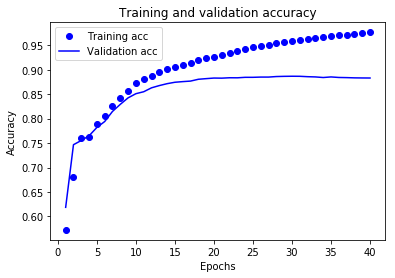

In [14]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()